In [1]:
from load_dataset import load_dataset
from mendel import AskMendel
from filter_dataset import filter_genes, filter_cells, filter_outliers
from preprocessing import calculate_qc_metrics, pca
from data.services.read_configs import read_configs
from pipelines.base_pipeline import run_pipeline
from format_code import execute_code

configs = read_configs()

In [12]:
# Load dataset
adata = load_dataset(path_to_dataset="dataset/filtered_gene_bc_matrices/")

Filtering cells...
Filtering genes...
Calculating QC metrics...


/Users/ankushgarg/Desktop/environments/mendel/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


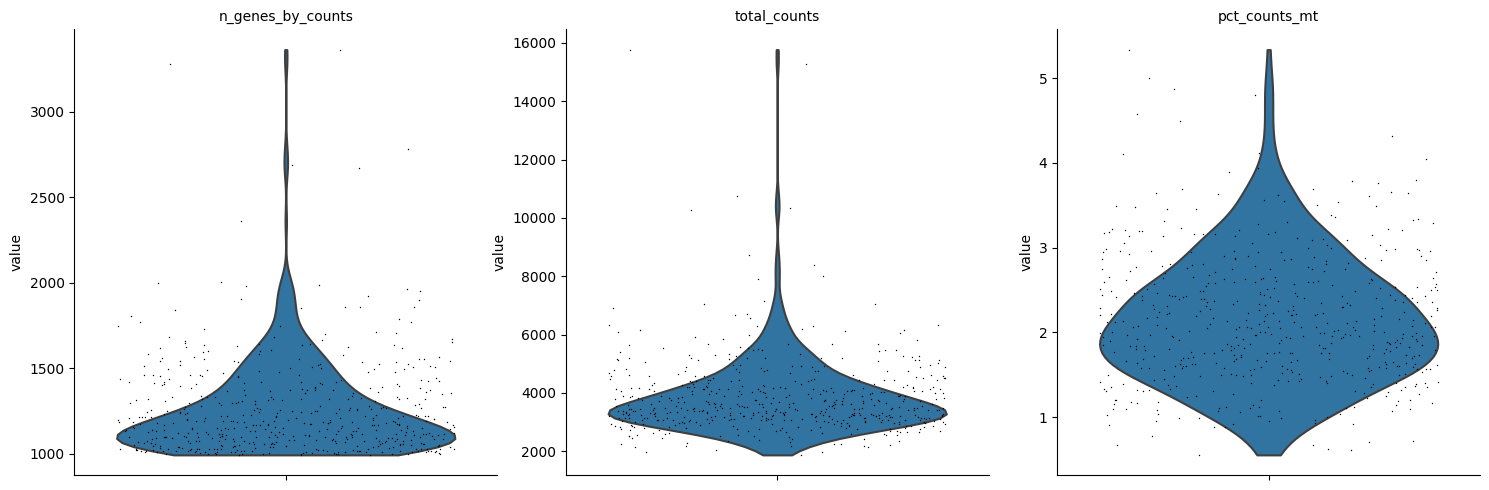

<Figure size 640x480 with 0 Axes>

In [13]:
run_pipeline(adata, configs, show_plots=True)

In [4]:
mendel = AskMendel()
prompt = "Can you plot `n_genes_by_counts` against `total_counts` in a scatter plot?"
plan_response = mendel.generate_plan(
    data=adata,
    prompt=prompt
)

In [5]:
print(plan_response)

- Extract the `n_genes_by_counts` and `total_counts` columns from the `adata` object.
- Create a scatter plot with `n_genes_by_counts` on the x-axis and `total_counts` on the y-axis.
- Label the x-axis as "Number of Genes" and the y-axis as "Total Counts".
- Add a title to the plot.
- Show the plot.


In [6]:
scatter_plot_response = mendel.ask(
    data=adata,
    prompt=prompt,
    plan=plan_response
)

In [7]:
import re
import io
from contextlib import redirect_stdout


def clean_up_code(code_to_run):
    START_CODE_TAG = "<startCode>"
    END_CODE_TAG = "<endCode>"
    separator: str = "```"
    match = re.search(
        rf"{START_CODE_TAG}(.*)({END_CODE_TAG}"
        rf"|{END_CODE_TAG.replace('<', '</')}"
        rf"|{START_CODE_TAG.replace('<', '</')})",
        code_to_run,
        re.DOTALL,
    )
    if match:
        code_to_run = match.group(1).strip()
    if len(code_to_run.split(separator)) > 1:
        code_to_run = code_to_run.split(separator)[1]

    if re.match(r"^(python|py)", code_to_run):
        code_to_run = re.sub(r"^(python|py)", "", code_to_run)
    if re.match(r"^`.*`$", code_to_run):
        code_to_run = re.sub(r"^`(.*)`$", r"\1", code_to_run)
    code_to_run = code_to_run.strip()
    return code_to_run
    
def run_code(code_to_run, adata):
    try:
        # Execute the code
        locals_dict = {"adata": adata}
        exec(code_to_run, globals(), locals_dict)
    
        adata = locals_dict["adata"]
        return code_to_run, adata
    except Exception as e:
            print(e)
    
    # # Redirect standard output to a StringIO buffer
    # with redirect_stdout(io.StringIO()) as output:
    #     count = 0
    #     print("here")
    #     try:
    #         # Execute the code
    #         locals_dict = {"adata": adata}
    #         exec(code_to_run, globals(), locals_dict)
    #         adata = locals_dict["adata"]
    #         return code_to_run, adata
    #     except Exception as e:
    #         print(e)

    

In [8]:
code_to_run = clean_up_code(scatter_plot_response)

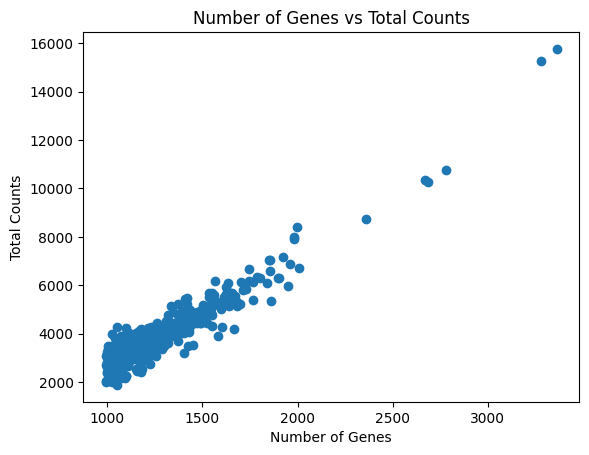

In [9]:
code, adata = run_code(code_to_run, adata)

In [10]:
adata = filter_outliers(adata, column_name="n_genes_by_counts", threshold=2500) # Change the name of the function

Filtering outliers...


In [11]:
adata.shape

(529, 11519)

In [14]:
filtering_dataset_plan = mendel.generate_plan(
    data=adata,
    prompt="Let's keep cells that have less than 3000 total_counts."
)

In [15]:
print(filtering_dataset_plan)

To keep cells that have less than 3000 total_counts, we can follow these steps:

1. Calculate the total_counts for each cell by summing up the expression values of all genes.
2. Filter out the cells that have total_counts greater than or equal to 3000.
3. Keep the remaining cells in the dataset.


In [20]:
new_plan = """
- Filter the cells based on the condition that n_genes_by_counts is less than 2000 and total counts is less than 8000.
- Create a new anndata object with the filtered cells.
"""

response = mendel.ask(
    adata,
    prompt="Let's keep cells that have less than 3000 total_counts.",
    plan=new_plan
)

In [21]:
code_to_run = clean_up_code(response)

code, adata = run_code(code_to_run, adata)

In [32]:
response = mendel.ask(
    data=adata,
    prompt="Can you plot `n_genes_by_counts` against `total_counts` in a scatter plot?",
    plan=plan_response
)

In [33]:
code_to_run = clean_up_code(response)

In [37]:
code_to_run = """

import scanpy as sc
import matplotlib.pyplot as plt

# Extract the n_genes_by_counts and total_counts columns from the adata object
n_genes_by_counts = adata.obs['n_genes_by_counts']
total_counts = adata.var['total_counts']

# Create a scatter plot with n_genes_by_counts on the x-axis and total_counts on the y-axis
plt.scatter(n_genes_by_counts, total_counts)

# Label the x-axis as "Number of Genes" and the y-axis as "Total Counts"
plt.xlabel("Number of Genes")
plt.ylabel("Total Counts")

# Add a title to the plot
plt.title("Number of Genes vs Total Counts")

# Show the plot
plt.show()

"""

setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 32.


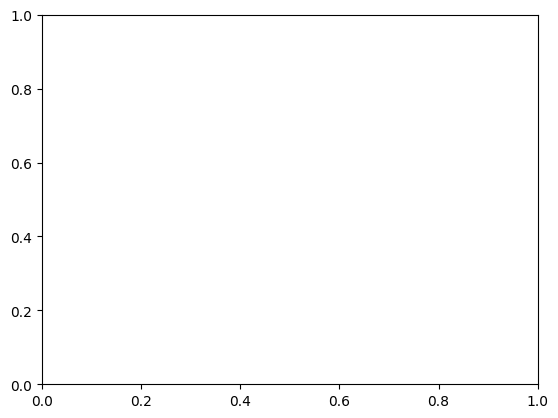

In [38]:
run_code(code_to_run, adata)